In [722]:
import numpy as np
import pandas as pd
import sys
import os 
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import glob

import sys
print(sys.path)

from sglm import utils, glm_fit

#d1 - T430
#d2 - T434

['c:\\Users\\Livia\\Desktop\\photometry_liv\\photometry_preprocessing\\sabatini-glm-workflow\\notebooks', 'c:\\Users\\Livia\\.conda\\envs\\glm\\python311.zip', 'c:\\Users\\Livia\\.conda\\envs\\glm\\DLLs', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib', 'c:\\Users\\Livia\\.conda\\envs\\glm', '', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib\\site-packages', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib\\site-packages\\win32', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Livia\\.conda\\envs\\glm\\Lib\\site-packages\\Pythonwin']


## Create a project

#### First, let's create a new project. The project directory will create a data and results folder and a config file.

#### You will need to edit the config file with the particular glm params you wish to use. Fields that are necessary to edit are: predictors, predictors_shift_bounds, response, and the glm_keyword_args.

#### You will also need to move your data into the data folder.

In [723]:
project_name = 'T430_newHist_glm' #'D1_h3Hist_all_glm' 
project_dir = r'\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Livia\\glm_output' # windows
# project_dir = r'/Volumes/Neurobio/MICROSCOPE/Livia/glm_output' # mac

utils.create_new_project(project_name, project_dir)

Project directory already exists!


'\\\\research.files.med.harvard.edu\\\\Neurobio\\\\MICROSCOPE\\\\Livia\\\\glm_output\\T430_newHist_glm\\config.yaml'

# Import and Format Data

Input data should conform to the following convention and be saved as a *.csv:

Indices / Unique Row Identifiers:
* SessionName -- Any order is acceptable
* TrialNumber-- Must be in chronological order, but does not need to start from zero
* Timestamp -- Must be in chronological order, but does not need to start from zero

Columns (Predictors + Responses):
* Predictors - binary
* Reponses - e.g. neural responses (analog or binary)

Example, shown below is dummy data depicting a trial_0 that last four response timestamps:
| SessionName | TrialNumber | Timestamp | predictor_1 | predictor_2 | predictor_3 | response_1 | response_2 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| session_0 | trial_0 | -1 | 0 | 0 | 0 | 1 | 0.3 |
| session_0 | trial_0 | 0 | 0 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_0 | 1 | 0 | 0 | 0 | 1 | 2.3 |
| session_0 | trial_0 | 2 | 0 | 1 | 0 | 1 | 0.3 |
| session_0 | trial_1 | -2 | 0 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_1 | -1 | 0 | 0 | 0 | 1 | 2.3 |
| session_0 | trial_1 | 0 | 1 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_1 | 1 | 0 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_0 | 5 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_0 | 6 | 1 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_0 | 7 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_0 | 8 | 0 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_1 | 9 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_1 | 10 | 0 | 0 | 0 | 1 | 2.3 |
....

#### Now, let's get set up to start our project

In [724]:
project_path = os.path.join(project_dir, project_name)
files = os.listdir(project_path)

assert 'data' in files, 'data folder not found! {}'.format(files)
assert 'results' in files, 'results folder not found! {}'.format(files)
assert 'config.yaml' in files, 'config.yaml not found! {}'.format(files)

#### If needed, use the following function to combine multiple sessions into one csv. You will need a filename you wish to call your output_csv

In [725]:
left = False
if left:
    # output_csv = 'output.csv'
    p_split = project_name.split("_")
    p_name = p_split[0][:len(p_split[0])-1]
    name = p_name +"_"+ p_split[1]
    print(name)
    output_csv = name +'Format.csv'
else: output_csv = project_name +'Format.csv'

output_csv
# utils.combine_csvs(project_path, output_csv)

'T430_newHist_glmFormat.csv'

#### Next, we'll open the data and set the columns you wish to use as fixed indices

In [726]:
input_file = os.path.join(project_path, 'data', output_csv)
index_col = ['SessionName', 'TrialNumber', 'Timestamp']

df = utils.read_data(input_file, index_col)

print('Your dataframe has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
df

Your dataframe has 537902 rows and 23 columns


AA_cue  Aa_cue  aa_cue  aB_cue  \
SessionName     TrialNumber Timestamp                                     
T430_2023_07_26 3004.0      2.349957        0.0     0.0     0.0     0.0   
                            2.370601        0.0     0.0     0.0     0.0   
                            2.391245        0.0     0.0     0.0     0.0   
                            2.411889        0.0     0.0     0.0     0.0   
                            2.432532        0.0     0.0     0.0     0.0   
...                                         ...     ...     ...     ...   
T430_2023_08_08 4031.0      1841.323868     0.0     0.0     0.0     0.0   
                            1841.344512     0.0     0.0     0.0     0.0   
                            1841.365156     0.0     0.0     0.0     0.0   
                            1841.385800     0.0     0.0     0.0     0.0   
                            1841.406444     0.0     0.0     0.0     0.0   

                                         AB_cue  Ab_cue  Select_L  Select_R  \
SessionName     TrialNumber Timestamp                                         
T430_2023_07_26 3004.0      2.349957        0.0     0.0         0         0   
                            2.370601        0.0     0.0         0         0   
                            2.391245        0.0     0.0         0         0   
                            2.411889        0.0     0.0         0         0   
                            2.432532        0.0     0.0         0         0   
...                                         ...     ...       ...       ...   
T430_2023_08_08 4031.0      1841.323868     0.0     0.0         0         0   
                            1841.344512     0.0     0.0         0         0   
                            1841.365156     0.0     0.0         0         0   
                            1841.385800     0.0     0.0         0         0   
                            1841.406444     0.0     0.0         0         0   

                                         enl1000  enl1250  ...  \
SessionName     TrialNumber Timestamp                      ...   
T430_2023_07_26 3004.0      2.349957         1.0      0.0  ...   
                            2.370601         0.0      0.0  ...   
                            2.391245         0.0      0.0  ...   
                            2.411889         0.0      0.0  ...   
                            2.432532         0.0      0.0  ...   
...                                          ...      ...  ...   
T430_2023_08_08 4031.0      1841.323868      0.0      0.0  ...   
                            1841.344512      0.0      0.0  ...   
                            1841.365156      0.0      0.0  ...   
                            1841.385800      0.0      0.0  ...   
                            1841.406444      0.0      0.0  ...   

                                         Consumption_R_R  Consumption_R_L  \
SessionName     TrialNumber Timestamp                                       
T430_2023_07_26 3004.0      2.349957                 0.0              0.0   
                            2.370601                 0.0              0.0   
                            2.391245                 0.0              0.0   
                            2.411889                 0.0              0.0   
                            2.432532                 0.0              0.0   
...                                                  ...              ...   
T430_2023_08_08 4031.0      1841.323868              0.0              0.0   
                            1841.344512              0.0              0.0   
                            1841.365156              0.0              0.0   
                            1841.385800              0.0              0.0   
                            1841.406444              0.0              0.0   

                                         Consumption_UR_R  Consumption_UR_L  \
SessionName     TrialNumber Timestamp                                         
T430_2023_07_26 30

#### You can now explore and add to the dataframe. As an example, you may want to add various "predictors" or "features" to explore. You can use the example below as inspiration

In [727]:
# #Identify the individual licks that have specific meaning in the tasks: 
# #lick 1, lick 2 and lick 3 are "operant licks" on different training days
# #licknon1-3 are all the other licks

# df_source = df.copy()
# srs_lick = df_source.groupby(['SessionName', 'TrialNumber'])['Lick'].cumsum()
# srs_lick_count = srs_lick * df_source['Lick']
# df_lick_count_dummies = pd.get_dummies(srs_lick_count).drop(0, axis=1)
# df_lick_count_dummies = df_lick_count_dummies[[1,2,3]]
# df_lick_count_dummies['non1-3'] = df_source['Lick'] - df_lick_count_dummies.sum(axis=1)
# df_lick_count_dummies.columns = [f'lick_{original_column_name}' for original_column_name in df_lick_count_dummies.columns]

# # Columns lick and lick_1, lick_2, lick_3, lick_non-13 should not all be used together
# # as predictors because of multicollinearity.
# df_source = pd.concat([df_source, df_lick_count_dummies], axis=1)
# df_source

# assert np.all(df_source['Lick'] == df_source[['lick_1', 'lick_2', 'lick_3', 'lick_non1-3']].sum(axis=1)), 'Column lick should equal the sum of all other lick columns.'

#### Friendly reminder, the df we have imported is mutli-index, meaning, it's organization is dependent on 3-columns that we have set in index_col. Therefore, we can use "groupby" if you need to split the organization. 

In [728]:
# reIndex = df_source.groupby(level=[0, 1])

## Load your fitting paramaters and set up your train/test data

In [729]:
config_file = os.path.join(project_path, 'config.yaml')
config = utils.load_config(config_file)
config

{'Project': {'project_name': 'T434_h2Hist_glm',
  'project_path': '\\\\research.files.med.harvard.edu\\\\Neurobio\\\\MICROSCOPE\\\\Livia\\\\glm_output\\T434_h2Hist_glm'},
 'glm_params': {'glm_keyword_args': {'alpha': 0.0025,
   'cv': 5,
   'fit_intercept': True,
   'l1_ratio': 0.5,
   'max_iter': 1000,
   'n_alphas': 100,
   'n_jobs': -1,
   'score_metric': 'r2',
   'selection': 'cyclic',
   'warm_start': False},
  'predictors': ['aB_cue',
   'AA_cue',
   'Ab_cue',
   'aa_cue',
   'Aa_cue',
   'AB_cue',
   'Select_R',
   'Select_L',
   'enl1000',
   'enl1250',
   'enl1500',
   'enl1750',
   'enl2000',
   'Consumption_R_R',
   'Consumption_UR_R',
   'Consumption_R_L',
   'Consumption_UR_L',
   'Cons_more_R_R',
   'Cons_more_R_L',
   'Cons_more_UR_R',
   'Cons_more_UR_L'],
  'predictors_shift_bounds': {'aB_cue': [-37, 75],
   'AA_cue': [-37, 75],
   'Ab_cue': [-37, 75],
   'aa_cue': [-37, 75],
   'Aa_cue': [-37, 75],
   'AB_cue': [-37, 75],
   'Select_R': [-75, 75],
   'Select_L': [-75, 

#### Shift responses and predictors. If you do not want to shift your predictors by an amount you set, feel free to comment out the entire "predictors_shift_bounds" in config.yaml. We will then use the default set when we created the config file.

In [730]:
for col in df.columns:
    print(col, df[col].unique())

AA_cue [0. 1.]
Aa_cue [0. 1.]
aa_cue [0. 1.]
aB_cue [0. 1.]
AB_cue [0. 1.]
Ab_cue [0. 1.]
Select_L [0 1]
Select_R [0 1]
enl1000 [1. 0.]
enl1250 [0. 1.]
enl1500 [0. 1.]
enl1750 [0. 1.]
enl2000 [0. 1.]
Consumption_R_R [0. 1.]
Consumption_R_L [0. 1.]
Consumption_UR_R [0. 1.]
Consumption_UR_L [0. 1.]
Cons_more_R_R [0. 1.]
Cons_more_R_L [0. 1.]
Cons_more_UR_R [0. 1.]
Cons_more_UR_L [0. 1.]
z_grnR [        nan -1.09577933 -1.10007466 ...  2.04145381  1.96208718
  1.88957634]
z_grnL [        nan -1.28348246 -1.27046458 ...  1.64104942  1.58027741
  1.56412653]


In [731]:
response_shift, df_predictors_shift, shifted_params = glm_fit.shift_predictors(config, df)
print('Your dataframe was shifted using: {}'.format(shifted_params))

df_predictors_shift.shape


Your dataframe was shifted using: [('aB_cue', [-37, 75]), ('AA_cue', [-37, 75]), ('Ab_cue', [-37, 75]), ('aa_cue', [-37, 75]), ('Aa_cue', [-37, 75]), ('AB_cue', [-37, 75]), ('Select_R', [-75, 75]), ('Select_L', [-75, 75]), ('enl1000', [0, 50]), ('enl1250', [0, 13]), ('enl1500', [0, 13]), ('enl1750', [0, 13]), ('enl2000', [0, 13]), ('Consumption_R_R', [-75, 75]), ('Consumption_UR_R', [-75, 75]), ('Consumption_R_L', [-75, 75]), ('Consumption_UR_L', [-75, 75]), ('Cons_more_R_R', [-75, 75]), ('Cons_more_R_L', [-75, 75]), ('Cons_more_UR_R', [-75, 75]), ('Cons_more_UR_L', [-75, 75])]


(480710, 2295)

In [732]:
df_predictors_shift

aB_cue                                \
                                           -37  -36  -35  -34  -33  -32  -31   
SessionName     TrialNumber Timestamp                                          
T430_2023_07_26 3037.0      180.072776     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            180.093420     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            180.114063     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            180.134707     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            180.155351     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                        ...  ...  ...  ...  ...  ...  ...   
T430_2023_08_08 4031.0      1839.775580    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1839.796224    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1839.816868    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1839.837512    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1839.858156    0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                                        ... Cons_more_UR_L  \
                                         -30  -29  -28  ...             66   
SessionName     TrialNumber Timestamp                   ...                  
T430_2023_07_26 3037.0      180.072776   0.0  0.0  0.0  ...            0.0   
                            180.093420   0.0  0.0  0.0  ...            0.0   
                            180.114063   0.0  0.0  0.0  ...            0.0   
                            180.134707   0.0  0.0  0.0  ...            0.0   
                            180.155351   0.0  0.0  0.0  ...            0.0   
...                                      ...  ...  ...  ...            ...   
T430_2023_08_08 4031.0      1839.775580  0.0  0.0  0.0  ...            0.0   
                            1839.796224  0.0  0.0  0.0  ...            0.0   
                            1839.816868  0.0  0.0  0.0  ...            0.0   
                            1839.837512  0.0  0.0  0.0  ...            0.0   
                            1839.858156  0.0  0.0  0.0  ...            0.0   

                                                                            \
                                          67   68   69   70   71   72   73   
SessionName     TrialNumber Timestamp                                        
T430_2023_07_26 3037.0      180.072776   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            180.093420   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            180.114063   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            180.134707   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            180.155351   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                      ...  ...  ...  ...  ...  ...  ...   
T430_2023_08_08 4031.0      1839.775580  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1839.796224  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1839.816868  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1839.837512  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                            1839.858156  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                                   
                                          74   75  
SessionName     TrialNumber Timestamp              
T430_2023_07_26 3037.0      180.072776   0.0  0.0  
                            180.093420   0.0  0.0  
                            180.114063   0.0  0.0  
                            180.134707   0.0  0.0  
                            180.155351   0.0  0.0  
...                                      ...  ...  
T430_2023_08_08 4031.0      1839.775580  0.0  0.0  
                            1839.796224  0.0  0.0  
                            1839.816868  0.0  0.0  
                            1839.837512  0.0  0.0  
                            1839.858156  0.0  0.0  

[480

In [733]:
enl_columns = df_predictors_shift.filter(like='enl', axis=1)
session = 'T430_2023_08_14'
filt_ind = [ind for ind, col in enumerate(enl_columns.index) if session in col]

rows_taken = [col for col in enl_columns.index if session in col]
print(F"{session} rows num: {len(rows_taken)}")

combined_all = enl_columns.iloc[filt_ind].sum(axis=1)
for com in combined_all.unique():
    print(f"{com} number: {len(np.where(combined_all == com)[0])}")
combined_all


T430_2023_08_14 rows num: 59063
1.0 number: 18090
2.0 number: 556
0.0 number: 40417


SessionName      TrialNumber  Timestamp  
T430_2023_08_14  4313.0       314.608681     1.0
                              314.629325     1.0
                              314.649969     1.0
                              314.670612     1.0
                              314.691256     1.0
                                            ... 
                 4579.0       1649.067786    0.0
                              1649.088430    0.0
                              1649.109074    0.0
                              1649.129718    0.0
                              1649.150362    0.0
Length: 59063, dtype: float64

In [734]:
print(f"{0} number: {np.where(combined_all == 0)[0]}")

test = enl_columns.iloc[80:100]
# test


0 number: [   35    36    37 ... 59060 59061 59062]


In [735]:
#create sparse array - by row
# import scipy
# sparse_df = scipy.sparse.csr_array(df_predictors_shift)

In [736]:
# sparse_df

### Create your test/train datasets

In [737]:
## X_train,X_test, y_train, y_test = glm_fit.split_data(df_predictors_shift, temp, config) 
# X_train,X_test, y_train, y_test = glm_fit.split_data(sparse_df, temp, config) 

# import trial_split

def hist(set):
    import numpy as np
    import matplotlib.pyplot as plt

    # Create a histogram
    plt.hist(set, bins=len(np.unique(set)), color='blue', alpha=0.7)

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')

    # Show the plot
    plt.show()
    

def renumber_trials(trials):
    
    arr = trials.copy()       
    found_ind = []
    count = 0
    new_tn = []

    unique_values, ind = np.unique(arr, axis=0, return_index=True)
    for i in ind:
        val_ind = np.where(np.all(arr == arr[i, :], axis=1))[0]
        found_ind.extend(val_ind)
        new_tn.extend(np.full_like(val_ind, count)) 
        count += 1
    
    new_tn = np.array(new_tn)
    return new_tn

'''
    for i in range(len(arr)):
    
        if i == 0:
            # print(f"first trial: {count}")
            # print(f"session, trial#: {arr[i, :]}")
            
            # print(f"found arr: {found}")
            val_ind = np.where(np.all(arr == arr[i, :], axis=1))[0]
            found_ind.extend(val_ind)
            # print(f"found indexes: {found_ind}")
            new_tn.extend(np.full_like(val_ind, count)) 
            # print(f"trial numbering: {new_tn}")
        else:
            if any(np.array_equal(i, found_elem) for found_elem in found_ind):
                continue
            else:
                count += 1
                # print(f"new trial: {count}")
                # print(f"session, trial#: {arr[i, :]}")
                # print(f"found new session: {count}")          
                
                # print(f"found arr: {found}")
                val_ind = np.where(np.all(arr == arr[i, :] , axis=1))[0]
                found_ind.extend(val_ind)
                # print(f"found indexes: {found_ind}")
                new_tn.extend(np.full_like(val_ind, count)) 
                # print(f"trial numbering: {new_tn}")
                    
    found_ind = np.array(found_ind)
    new_tn = np.array(new_tn)
    
    # print(f"final found indexes: {found_ind}")
    if np.array_equal(found_ind, np.arange(len(trials))):
        # print(f"final new trial numbering: {new_tn}")
        return new_tn
    else: 
        print("ERROR not all indexes reassigned trial number")
        return np.nan
'''

# test = np.vstack((np.array(['a', 'a', 'b', 'c', 'd', 'e', 'f']).astype(str), np.array([1, 1, 2, 2, 3, 4, 1]).astype(float))).transpose()
# print(test)  
# new = renumber_trials(test)    
# new

'\n    for i in range(len(arr)):\n    \n        if i == 0:\n            # print(f"first trial: {count}")\n            # print(f"session, trial#: {arr[i, :]}")\n            \n            # print(f"found arr: {found}")\n            val_ind = np.where(np.all(arr == arr[i, :], axis=1))[0]\n            found_ind.extend(val_ind)\n            # print(f"found indexes: {found_ind}")\n            new_tn.extend(np.full_like(val_ind, count)) \n            # print(f"trial numbering: {new_tn}")\n        else:\n            if any(np.array_equal(i, found_elem) for found_elem in found_ind):\n                continue\n            else:\n                count += 1\n                # print(f"new trial: {count}")\n                # print(f"session, trial#: {arr[i, :]}")\n                # print(f"found new session: {count}")          \n                \n                # print(f"found arr: {found}")\n                val_ind = np.where(np.all(arr == arr[i, :] , axis=1))[0]\n                found_ind.extend(

In [738]:
trialsss = (np.vstack((np.array(df_predictors_shift.index.get_level_values(0)).astype(str), df_predictors_shift.index.get_level_values(1)))).transpose()


In [739]:
def test_train_split_trials(config, df, y):
    
    trials = (np.vstack((np.array(df.index.get_level_values(0)).astype(str), df.index.get_level_values(1)))).transpose()
    # print(trials)
 
    # new_trial_numbering = renumber_trials(trials)
    # mapping = np.vstack((df.index.get_level_values(1), new_trial_numbering)).transpose()
    
    ind = {
    'session': np.array(df.index.get_level_values(0)).astype(str),
    'trial_num_new': df.index.get_level_values(1) # new_trial_numbering
    }
    arrays = list(zip(ind['session'], ind['trial_num_new']))
    multi_index = pd.MultiIndex.from_tuples(arrays, names=('session', 'trial_num_new'))
    df.set_index(multi_index, inplace=True)
    
    train_size = config['train_test_split']['train_size']
    test_size = config['train_test_split']['test_size']
    
    print(train_size, test_size)
    
    # new_trials = (np.vstack((np.array(df.index.get_level_values(0)).astype(str), df.index.get_level_values(1)))).transpose()

    # print(new_trials[:, 1])
    # hist(new_trials[:, 1])
    
    # unique_values, unique_ind, unique_count = np.unique(new_trials[:, 1], return_index=True, return_counts=True)
    unique_values, unique_ind, unique_count = np.unique(trials[:, 1], return_index=True, return_counts=True)

    print(f"unique val: {unique_values}")
    print(f"unique ind: {unique_ind}")
    # hist(unique_values)
    print(f"unique count {unique_count}")
    
    sample_size = int(test_size * len(unique_values))
    test_sample = np.random.choice(unique_values, size=sample_size, replace=False)
    # print(f"testsample: {test_sample}")
    
    print(f"test:train ratio: {len(test_sample) / len(unique_values)}:{(len(unique_values)-len(test_sample))/len(unique_values)}")
    
    ind = []
    for test in test_sample:
        val_ind = np.where(trials[:, 1] == test)[0]
        ind.extend(val_ind)
        
    print(f"ind {ind}")
    
    copy = df_predictors_shift.copy()
    copy = copy.reset_index(drop=True)
    X_test = copy.loc[ind, :]
    X_train = copy.drop(index=ind)
    y_test = y[ind]
    y_train = np.delete(y, ind)
    test_ind = df.index.get_level_values(1)[ind] #new_trial_numbering[ind]
    
    return mapping, test_ind, X_train, X_test, y_train, y_test #X_train,X_test, y_train, y_test

# X_train,X_test, y_train, y_test = trial_split(config, df, temp)
mapping, test_list, X_train,X_test, y_train, y_test = test_train_split_trials(config, df_predictors_shift, response_shift.values.flatten())

# print('Training data has {} rows and {} columns'.format(X_train.shape[0], X_train.shape[1]))
# print('Testing data has {} rows and {} columns'.format(X_test.shape[0], X_test.shape[1]))


0.8 0.2
unique val: ['2424.0' '2425.0' '2428.0' ... '5205.0' '5206.0' '5207.0']
unique ind: [232155 232384 232636 ... 172427 172669 172934]
unique count [229 252 242 ... 242 265 158]
test:train ratio: 0.19970486965076242:0.8002951303492376
ind [31912, 31913, 31914, 31915, 31916, 31917, 31918, 31919, 31920, 31921, 31922, 31923, 31924, 31925, 31926, 31927, 31928, 31929, 31930, 31931, 31932, 31933, 31934, 31935, 31936, 31937, 31938, 31939, 31940, 31941, 31942, 31943, 31944, 31945, 31946, 31947, 31948, 31949, 31950, 31951, 31952, 31953, 31954, 31955, 31956, 31957, 31958, 31959, 31960, 31961, 31962, 31963, 31964, 31965, 31966, 31967, 31968, 31969, 31970, 31971, 31972, 31973, 31974, 31975, 31976, 31977, 31978, 31979, 31980, 31981, 31982, 31983, 31984, 31985, 31986, 31987, 31988, 31989, 31990, 31991, 31992, 31993, 31994, 31995, 31996, 31997, 31998, 31999, 32000, 32001, 32002, 32003, 32004, 32005, 32006, 32007, 32008, 32009, 32010, 32011, 32012, 32013, 32014, 32015, 32016, 32017, 32018, 32019,

In [740]:
print(len(y_test)/len(y_train), len(X_test)/len(X_train))
y_test.shape, y_train.shape, X_test.shape, X_train.shape


0.2473629992137651 0.2473629992137651


((95329,), (385381,), (95329, 2295), (385381, 2295))

346930x2526 sparse array of type '<class 'numpy.float64'>'
	with 3242262 stored elements in Compressed Sparse Row format>

In [741]:
import scipy
# y_train_sp = scipy.sparse.csr_array(y_train)
# y_test_sp = scipy.sparse.csr_array(y_test)
x_train_sp = scipy.sparse.csr_array(X_train)
x_test_sp = scipy.sparse.csr_array(X_test)

In [742]:
x_train_sp, x_test_sp #, y_test_sp, y_train_sp

(<385381x2295 sparse array of type '<class 'numpy.float64'>'
 	with 3605638 stored elements in Compressed Sparse Row format>,
 <95329x2295 sparse array of type '<class 'numpy.float64'>'
 	with 899691 stored elements in Compressed Sparse Row format>)

In [743]:
# y_test1 = (y_test.values).flatten()
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((95329, 2295), (95329,), (385381, 2295), (385381,))

## Now, we're ready to run our GLM!

### We have two different options. If you know which params you would like to use, you can use the glm_fit.fit_glm function. If you would like tune your hyperparams to determine which are the best to use, you can use the glm_fit.fit_tuned_glm function. 

In [744]:
# # Fit the model
model, y_pred, score, beta, intercept, sparse_beta = glm_fit.fit_glm(config, x_train_sp, x_test_sp, y_train, y_test)
print('Your model can account for {} percent of your data'.format(score*100))
modeltype = "fit"

ypred: [-0.18360713 -0.17297747 -0.15789693 ... -0.59149065 -0.53922723
 -0.54496266]
y: [-1.19673435 -1.20014603 -1.19176969 ... -1.04233733 -1.00571073
 -0.97268272]
Your model can account for 30.600652412527886 percent of your data


In [745]:
# Ridge Model:
model, y_pred, score, beta, intercept = glm_fit.fit_ridge(config, x_train_sp, x_test_sp, y_train, y_test)
print('Your model can account for {} percent of your data'.format(score*100))
modeltype = "fit"

ypred: [-0.28639012 -0.26636937 -0.23436588 ... -0.71256836 -0.67144691
 -0.67800727]
y: [-1.19673435 -1.20014603 -1.19176969 ... -1.04233733 -1.00571073
 -0.97268272]
Your model can account for 43.02861932352784 percent of your data


In [746]:
# Ridge Model CV:
# tuned_model, y_pred, score, beta, best_params = glm_fit.fit_tuned_ridge(config, X_train, X_test, y_train, y_test)
# print('Your model can account for {} percent of your data'.format(score*100))
# modeltype = "tuned"

In [747]:
def prep_plot(config, df):
    shifts = config['glm_params']['predictors_shift_bounds']
    # print(shifts)
    # col_list = []
    # index = []
    # len_shift = 0
    plot_df = pd.DataFrame()
    for key, value in shifts.items():
        # print(f"key = {key}")
        if key == 'z_grn':
            continue
        else:
            plot_df[key] = df[key]['0']
            '''
            # col_list.append(key)
            # # print(value, value[0], value[1])
            # head = value[0]
            # tail = value[1]
            # index.append(abs(head)+len_shift)
            # len_shift = abs(head)+abs(tail)+len_shift
            # # print(f"len sh = {len_shift}")
            '''
    # print(index)
            
    # plot_pd = pd.DataFrame(df.iloc[:, index], columns=col_list)
    
    return plot_df

In [748]:
plot_df = prep_plot(config, X_test)
plot_df = plot_df.set_index(test_list, drop=True)

In [749]:
# Fit the model with cross validation: remember, your alphas and l1_ratios should be lists
# tuned_model, y_pred, score, beta, best_params = glm_fit.fit_tuned_glm(config, X_train, X_test, y_train, y_test)
# print('Your model can account for {} percent of your data'.format(score*100))
# modeltype = 'tuned'

In [750]:
%matplotlib inline
import matplotlib.pyplot as plt

trials: Index([2741.0, 3798.0, 4269.0, 2906.0, 2567.0, 3196.0, 3235.0, 4105.0, 5003.0,
       4894.0, 2738.0, 3414.0, 3109.0, 4920.0, 3361.0, 5137.0, 5015.0, 4900.0,
       4380.0, 4408.0],
      dtype='float64', name='trial_num_new')


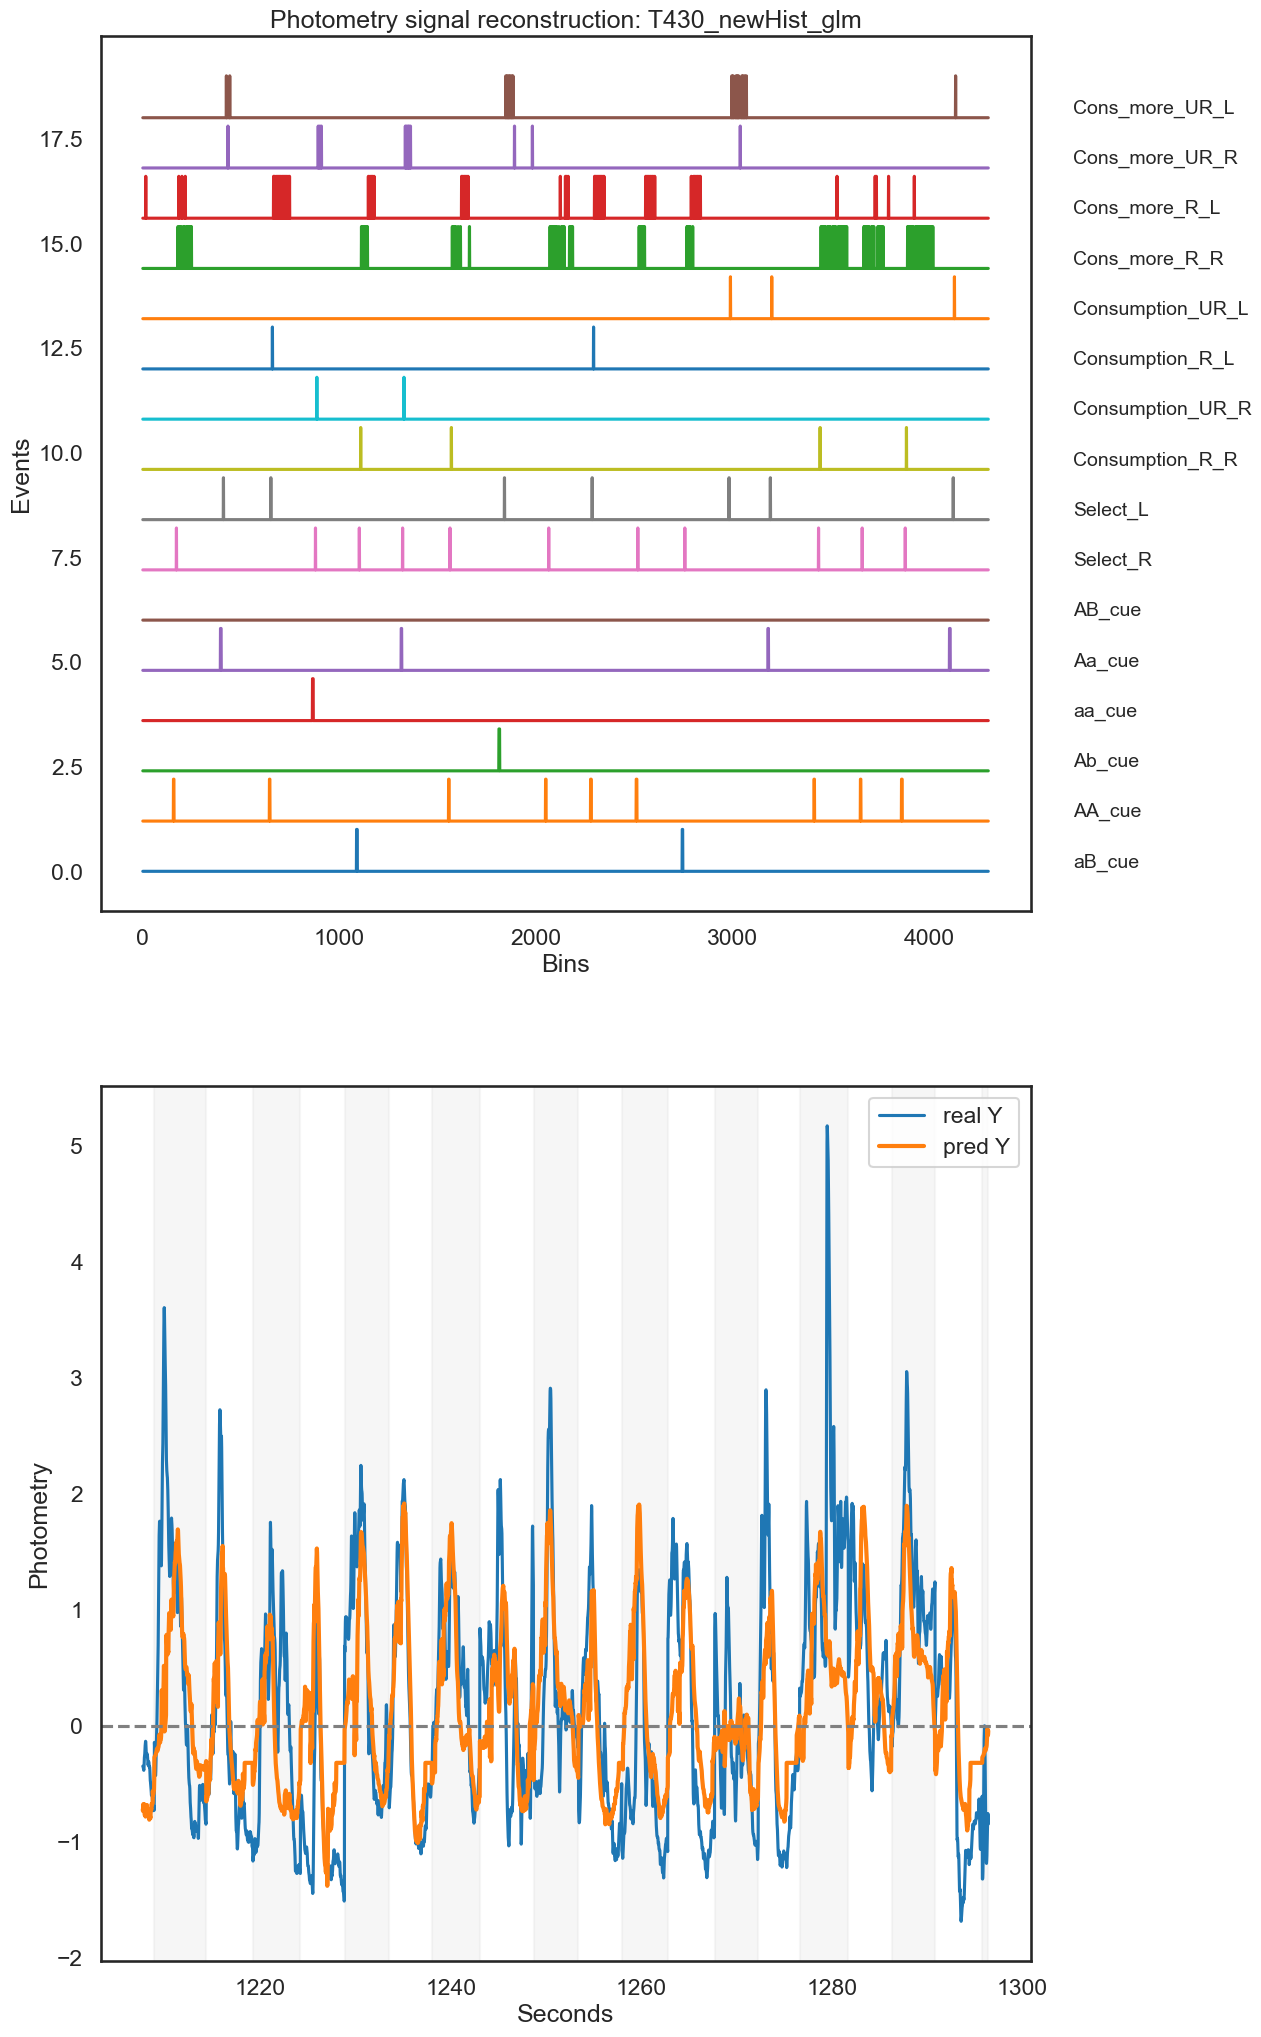

In [767]:
def normalize(x, window):
    
    r = x.rolling(window=window,center=True)
    
    lower_bound = r.min()
    upper_bound = r.max()
    #lower_bound = r.quantile(0.05) # instead of .min()
    #upper_bound = r.quantile(0.95) # instead of .max()
    
    return (x-lower_bound)/(upper_bound-lower_bound)
  
def plot_spikes_with_prediction(df, spikes, predicted_spikes, fs, **kws):
  """Plot actual and predicted spike counts.

  """

  f, ax = plt.subplots(2, figsize=(12, 25))
  # lines = ax.stem(t, spikes[:nt])
  # plt.setp(lines, color=".5")
  
  i=0
  inc_height=1.2
  window_start = 58500 #0  #10200 
  window_stop = 62800 #len(spikes) #10500

  cols_to_plot = [col for col in df.columns]
  enl_columns = [col for col in df.columns if 'enl' in col]
  not_enl = [col for col in cols_to_plot if not any(enl_col in col for enl_col in enl_columns)]
  
  for j, col in enumerate(not_enl):
    if 'trial_num' in col:
      continue
    if 'z_grn' in col:
      ax[0].plot((df[col].values*0.2)[window_start:window_stop] + i, label=col)
    else:
      ax[0].plot((df[col].values)[window_start:window_stop] + i, label=col)
    i += inc_height
    ax[0].text(x=len(spikes[window_start:window_stop])+len(spikes[window_start:window_stop])*0.1, y=i - inc_height, s=col, fontsize=14, va="bottom")
  ax[0].set(
      xlabel="Bins",
      ylabel="Events",
      title=f"Photometry signal reconstruction: {project_name}"
  )
  
  t = (np.arange(0, len(spikes))*fs)[window_start:window_stop]

#_____________________
  trials = plot_df.index[window_start:window_stop]
  trial_call = trials.unique()
  print(f"trials: {trial_call}")

  for tt, trial in enumerate(trial_call):
    if tt%2 != 0:
      # print(t[np.where(trials == trial)[0][1]], t[np.where(trials == trial)[0][-1]])
      ax[1].axvspan(xmin=t[(np.where(trials == trial)[0])[0]], xmax=t[(np.where(trials == trial)[0])[-1]], ymin=-2, ymax=2, color='lightgrey', alpha=0.2)
  #____________________
  ax[1].plot(t, spikes[window_start:window_stop], label='real Y')
  # lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax[1].plot(t, predicted_spikes[window_start:window_stop], **kws, label='pred Y')
  ax[1].set(
      xlabel="Seconds",
      ylabel="Photometry",
  )
  ax[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax[1].axhline(y=0, color='grey', linestyle="--")
  # ax.legend([lines[0], yhat], ["Spikes", "Predicted"])
  ax[1].legend()

  plt.show()

fs = 1/48.440600198412696

input_df = prep_plot(config, X_test) #, test_list)
# plot_spikes_with_prediction(y_test, y_pred, df.Timestamp[1] - df.Timestamp[0])
plot_spikes_with_prediction(input_df, y_test, y_pred, fs)


In [752]:
# tri = 
# # print(mapping(np.where(mapping[1] == tri)[0]))
# test = plot_df[plot_df.index == tri]
# test

In [753]:
# f, ax = plt.subplots(1, figsize=(6, 12))
  
# i=0
# inc_height=1.2

# cols_to_plot = [col for col in test.columns]

# for j, col in enumerate(cols_to_plot):
#     ax.plot((test[col].values) + i, label=col)
#     i += inc_height
#     ax.text(x=10, y=i - inc_height, s=col, fontsize=14, va="bottom")
#     ax.set(
#         xlabel="Bins",
#         ylabel="Events",
#         title=f"Photometry signal reconstruction: {project_name}"
#     )

In [754]:
if modeltype == 'tuned':
    print(best_params)


## Save your outputs

In [755]:
#Create your model dictonary, this should include all the information you wish to save
if modeltype == "fit":
    model_dict = {'model': model,
              'y_pred': y_pred,
              'score': score,
              'beta': beta,
              'intercept': intercept,
              'sparse_beta': sparse_beta,}
if modeltype == 'tuned':
    model_dict = {'model': tuned_model,
              'y_pred': y_pred,
              'score': score,
              'beta': beta,
              'best_params': best_params,}
    

#Save your model dictionary
model_path = project_path + '/models'
model_name = project_name + '_model.pkl'
model_full_path = os.path.join(model_path, model_name)
import pickle
with open(model_full_path, 'wb') as f:
    pickle.dump(model_dict, f)
        
# glm_fit.save_model(model_dict, project_path)

## Generate and save figures

In [756]:
save_img = os.path.join(project_path)

glm_fit.plot_and_save(save_img, config, y_pred, y_test, beta, df_predictors_shift, format(score*100))

saved to: \\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Livia\\glm_output\T430_newHist_glm/results/model_fit.png


test - true: enl found
enl all shape: (107,)
model test shape: (182, 21)
saved to: \\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Livia\\glm_output\T430_newHist_glm/results/model_fit_comb.png


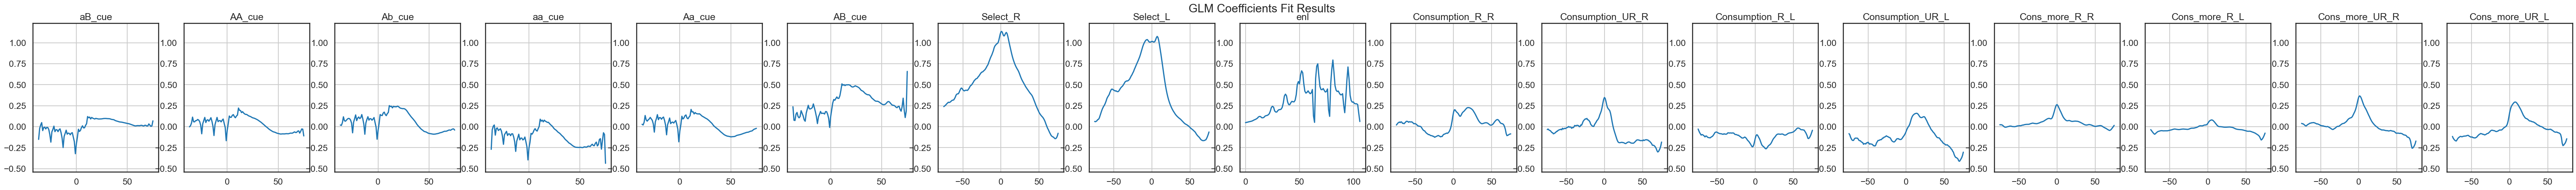

In [757]:
combine_enl = True
if combine_enl:
    #save model fit results
    model_fit_results = pd.Series(beta, index=df_predictors_shift.columns, name='coef').unstack(0, )
    model_fit_results.index = model_fit_results.index.astype(int)
    model_fit_results = model_fit_results.reindex(config['glm_params']['predictors'], axis=1)

    # new added by liv for enl appending:
    if any('enl' in col for col in model_fit_results.columns):
        # could add sorting for enl precursors ie. history?
        enl_columns = [col for col in model_fit_results.columns if 'enl' in col]
        enl_col_df = model_fit_results[enl_columns]
        # print(enl_col_df.shape)
        # for icol, col in enumerate(enl_col_df.columns):
            # print("col shape: " + col.shape)
            # print(f"col ind: {icol}")
            # print(f"col index pred shape: {enl_col_df.sort_index()[col]}")
        print("test - true: enl found")
            
        enl_all = np.array([])
        test = []
        for icol, col in enumerate(enl_col_df.columns):
            test.append(enl_col_df.sort_index()[col])
            nans = np.isnan(enl_col_df.sort_index()[col])
            enl_all = np.append(enl_all, enl_col_df.sort_index()[col][~nans])
            
        print(f"enl all shape: {enl_all.shape}")
        enl_df = pd.DataFrame({'enl': enl_all})
        
        test = np.where(enl_df['enl'] == 0)[0]
        model_test = model_fit_results.copy()
        # print(model_test.index)
        loc_insert = int((np.where(model_test.columns == enl_columns[0])[0])[0])
        
        model_test = model_test.sort_index()
        model_test = model_test.reindex(range(np.min(model_test.index), len(enl_all)))
        print(f"model test shape: {model_test.shape}")
            
        for col in enl_columns:
            # print(f"drop col: {str(col)}")
            model_test = model_test.drop(str(col), axis=1)

        # print(model_test.index)
        model_test = model_test.join(enl_df, how='left')
        col = model_test.pop('enl')
        model_test.insert(loc_insert, col.name, col)

        
        
    else:
        print("no enl found")

    ''' uncomment for comparison with and without joining enl:
    tup_y_lim = (np.inf, -np.inf)
    fig, axes = plt.subplots(1, len(model_fit_results.columns), figsize=(5*len(model_fit_results.columns), 5))
    axes = axes.flatten()
    for ipredictor, predictor in enumerate(model_fit_results.columns):
            
        axes[ipredictor].plot(model_fit_results.sort_index()[predictor])
        axes[ipredictor].set_title(predictor)
        axes[ipredictor].grid(True)
        
        tup_y_lim = (min(tup_y_lim[0], model_fit_results[predictor].min()-0.1),
                    max(tup_y_lim[1], model_fit_results[predictor].max()+0.1))

    for ax in axes:
        ax.set_ylim(tup_y_lim)
    fig.suptitle('GLM Coefficients Fit Results')
    '''
    ###########
    tup_y_lim = (np.inf, -np.inf)
    fig, axes = plt.subplots(1, len(model_test.columns), figsize=(5*len(model_test.columns), 5))
    axes = axes.flatten()
    for ipredictor, predictor in enumerate(model_test.columns):
        # print(f"predictor {predictor}")
            
        axes[ipredictor].plot(model_test.sort_index()[predictor])
        axes[ipredictor].set_title(predictor)
        axes[ipredictor].grid(True)
        
        tup_y_lim = (min(tup_y_lim[0], model_test[predictor].min()-0.1),
                    max(tup_y_lim[1], model_test[predictor].max()+0.1))

    for ax in axes:
        ax.set_ylim(tup_y_lim)
    fig.suptitle('GLM Coefficients Fit Results')
    plt.savefig(save_img + '/results/model_fit_comb.png')
    print(f"saved to: {save_img + '/results/model_fit_comb.png'}")
    plt.show()
    plt.close()

In [758]:
plot_df 
# np.where(plot_df['aB_cue'] == 1)[0]

,aB_cue,AA_cue,Ab_cue,aa_cue,Aa_cue,AB_cue,Select_R,Select_L,enl1000,enl1250,...,enl1750,enl2000,Consumption_R_R,Consumption_UR_R,Consumption_R_L,Consumption_UR_L,Cons_more_R_R,Cons_more_R_L,Cons_more_UR_R,Cons_more_UR_L
trial_num_new,,,,,,,,,,,,,,,,,,,,,
3224.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3224.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3224.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3224.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3224.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4703.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4703.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [770]:
# def plot_av_coef(config, df(X_test), enl, y):
def first_cue(trial, cues):
    
    cuetype = None
    for cue in cues:
        # print(cue)
        # print(np.where(trial[cue] == 1)[0])
        if len(np.where(trial[cue] == 1)[0]) > 0:
            cuetype = str(cue)
            time = np.where(trial[cue] == 1)[0][0]
            break
          
    if cuetype is None:
        print("no cue found - big problem")
        return cuetype, 0
    else:
        return cuetype, time
    
    
cols_to_plot = [col for col in plot_df.columns]
enl_columns = [col for col in plot_df.columns if 'enl' in col]
not_more = [col for col in plot_df.columns if not 'more' in col]
cues = [col for col in plot_df.columns if 'cue' in col]
not_ = [col for col in not_more if not 'enl' in col]
print(not_)

u, count = np.unique(plot_df.index, return_counts=True)
length = np.max(count)
averaged_event_df = pd.DataFrame()
real_event_df = pd.DataFrame()
    
for trial_num in plot_df.index.unique():
    trial = plot_df[plot_df.index == trial_num]
    y_trial = y_pred[plot_df.index == trial_num]
    y_real = y_test[plot_df.index == trial_num]
    # print(y_trial.shape, trial.shape)
    
    nones = []
    for col in not_:    
        if np.any((np.where(trial[col] == 1))[0]):
            cue_type, first_cue_ind = first_cue(trial, cues)
            if cue_type is None:
                nones.append([trial_num, col])
                #is this enl are they their own trials??
            # print(f"{cue_type}: {first_cue_ind}")
            
            event_new = y_trial[first_cue_ind:len(trial[col])] #HERE
            event_real = y_real[first_cue_ind:len(trial[col])]
            
            if col in averaged_event_df:
                a = averaged_event_df[col].values
                b = event_new
                b_nans = np.append(event_new, np.full(abs(len(b) - len(a)), np.nan))
                    
                mean_result = np.nanmean([a, b_nans], axis=0)  
            else:
                mean_result = event_new
                
            if col in real_event_df:
                c = real_event_df[col].values
                d = event_real
                d_nans = np.append(event_real, np.full(abs(len(d) - len(c)), np.nan))
                mean_real = np.nanmean([c, d_nans], axis=0)
            else:
                mean_real = event_real

            mean_result = np.append(mean_result, np.full(abs(length - len(mean_result)), np.nan))
            mean_real = np.append(mean_real, np.full(abs(length - len(mean_real)), np.nan))
            

            averaged_event_df[col] = mean_result  
            real_event_df[col] = mean_real          
            # print(f"shapes: {col, averaged_event_df[col].shape, len(mean_result)}")
            
    if len(nones) > 0:
        print(f"no cues?: {nones}") 




['aB_cue', 'AA_cue', 'Ab_cue', 'aa_cue', 'Aa_cue', 'AB_cue', 'Select_R', 'Select_L', 'Consumption_R_R', 'Consumption_UR_R', 'Consumption_R_L', 'Consumption_UR_L']
no cue found - big problem
no cue found - big problem
no cues?: [[5053.0, 'Select_R'], [5053.0, 'Consumption_R_R']]


C:\Users\Livia\AppData\Local\Temp\ipykernel_21296\1039665876.py:55: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_21296\1039665876.py:63: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_21296\1039665876.py:55: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_21296\1039665876.py:63: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_21296\1039665876.py:55: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_21296\1039665876.py:63: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_21296\1039665876.py:55: RuntimeWarning: Mean of em

no cue found - big problem
no cue found - big problem
no cues?: [[2595.0, 'Select_L'], [2595.0, 'Consumption_R_L']]
no cue found - big problem
no cue found - big problem
no cues?: [[4920.0, 'Select_L'], [4920.0, 'Consumption_UR_L']]
no cue found - big problem
no cues?: [[4790.0, 'Select_R']]


12
Index(['AA_cue', 'Select_L', 'Consumption_R_L', 'aa_cue', 'Select_R',
       'Consumption_UR_R', 'Consumption_R_R', 'Ab_cue', 'Consumption_UR_L',
       'Aa_cue', 'AB_cue', 'aB_cue'],
      dtype='object')


[Text(0.5, 1.0, 'Averaged signal reconstruction: T430_newHist_glm')]

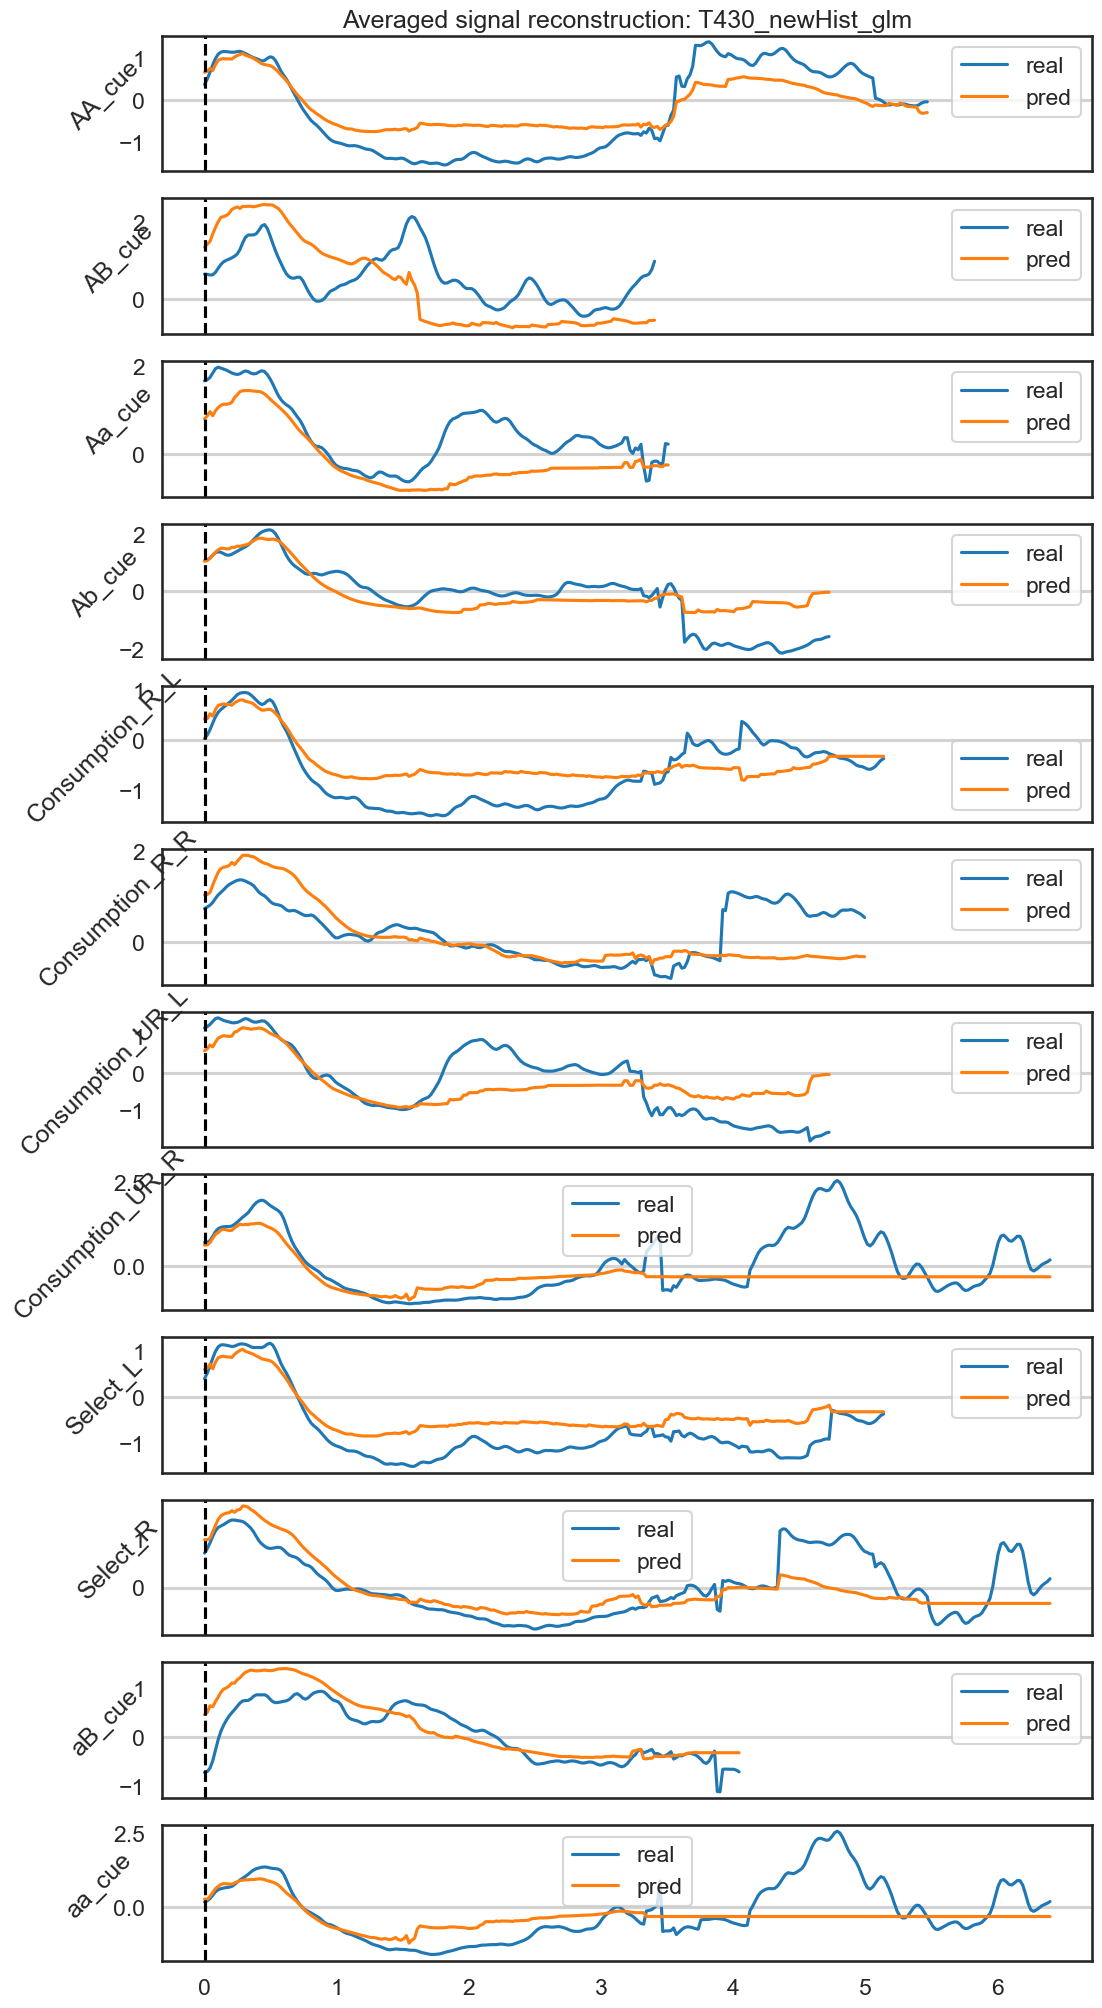

In [771]:
fig, ax = plt.subplots(len(averaged_event_df.columns), figsize=(12, 25), sharex=True)
print(len(averaged_event_df.columns))
print(averaged_event_df.columns)

for i, av in enumerate(np.sort(averaged_event_df.columns)): #cue select comsp: R, UR
    t = np.arange(0, len(averaged_event_df[av])) / 48.440600198412696
    t_real = np.arange(0, len(real_event_df[av])) / 48.440600198412696
    ax[i].axhline(y=0, color='lightgrey')
    ax[i].plot(t_real, real_event_df[av], label='real')
    ax[i].plot(t, averaged_event_df[av], label='pred')
    ax[i].set_ylabel(av, rotation = 45)
    ax[i].axvline(x=0, color='k', linestyle="--")
    ax[i].legend()
ax[0].set(
    title=f"Averaged signal reconstruction: {project_name}"
)


12
Index(['AA_cue', 'Select_L', 'Consumption_R_L', 'aa_cue', 'Select_R',
       'Consumption_UR_R', 'Consumption_R_R', 'Ab_cue', 'Consumption_UR_L',
       'Aa_cue', 'AB_cue', 'aB_cue'],
      dtype='object')


[Text(0.5, 1.0, 'Averaged signal reconstruction: T430_newHist_glm')]

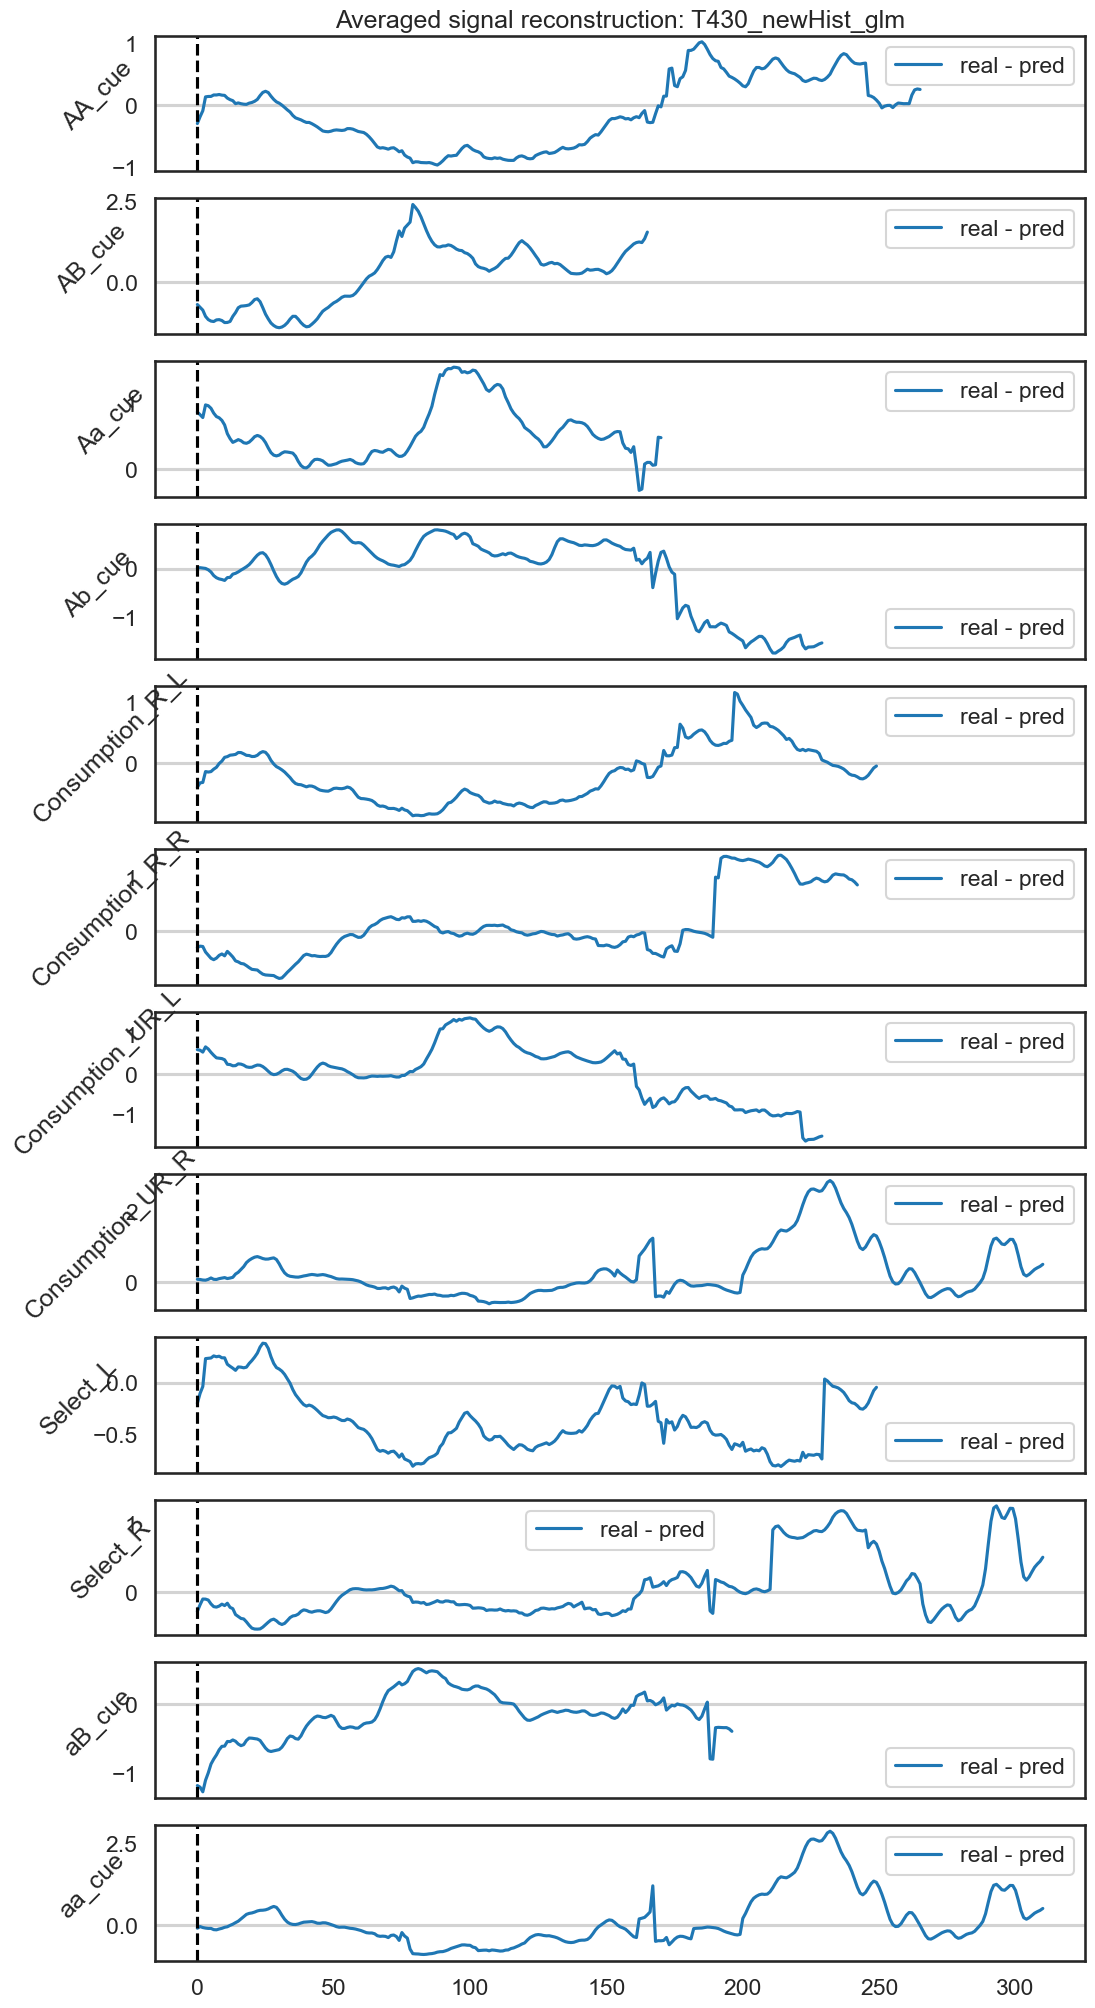

In [772]:
fig, ax = plt.subplots(len(averaged_event_df.columns), figsize=(12, 25), sharex=True)
print(len(averaged_event_df.columns))
print(averaged_event_df.columns)

for i, av in enumerate(np.sort(averaged_event_df.columns)):
    ax[i].axhline(y=0, color='lightgrey')
    ax[i].plot(real_event_df[av] - averaged_event_df[av], label='real - pred')
    # ax[i].plot(averaged_event_df[av], label='pred')
    ax[i].set_ylabel(av, rotation = 45)
    ax[i].axvline(x=0, color='k', linestyle="--")
    ax[i].legend()
ax[0].set(
    title=f"Averaged signal reconstruction: {project_name}"
)